In [4]:
#!mkdir OCT_small

In [1]:
import os
import pandas as pd
import random
random.seed(77)
import matplotlib.pyplot as plt
import glob

In [5]:
# 사용할 변수
# 1. 분류 기준 : 세 가지 질병 + 정상 상태 
symptoms = ["CNV", "DME", "DRUSEN", "NORMAL"]
# 2. 폴더 절대 경로
path_dirs = {"test_dir": "OCT2017/test/",
             "train_dir":  "OCT2017/train/"}
# 3. 이동할 경로 
goal_dir =  "OCT_small/train/"

In [7]:
#train 폴더 체크 
train_total = []
for name in symptoms : 
    get_list = os.listdir("OCT2017/train/" + name)
    train_total.extend(get_list)
len(train_total)

83484

In [8]:
train_total[:4]

['CNV-5557306-155.jpeg',
 'CNV-163081-153.jpeg',
 'CNV-3537912-28.jpeg',
 'CNV-7159021-147.jpeg']

In [9]:
#train 파일 리스트로 데이터프레임 만들기 
classify = []
patient = []
fileno = []

for name in train_total:
    classify.append(name.split("-")[0])
    patient.append(name.split("-")[1])
    fileno.append(name.split("-")[2].split(".")[0])
    
train_df = pd.DataFrame({"class":classify, "id":patient, "numbers":fileno})


train_des = train_df[["class", "id"]].groupby("class").count()
train_des["percentage"] = round(train_des["id"] / len(train_total), 4) *100 
train_des

,id,percentage
class,,
CNV,37205,44.57
DME,11348,13.59
DRUSEN,8616,10.32
NORMAL,26315,31.52


In [10]:
len(train_df), len(train_df["id"].unique())

(83484, 4590)

In [11]:
train_df.head()

,class,id,numbers
0,CNV,5557306,155
1,CNV,163081,153
2,CNV,3537912,28
3,CNV,7159021,147
4,CNV,8087608,23


([], [])

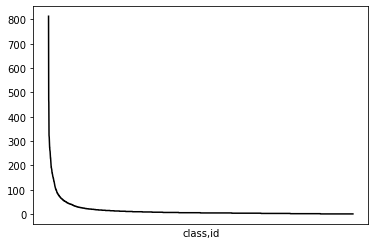

In [12]:
#환자 id 를 기준으로 value_counts -> id당 사진 몇 장인지 확인하기 
#불균형이 엄청 심함 

train_df[["class", "id"]].value_counts().plot(color="black")
plt.xticks(ticks=[])



In [13]:
#max가 813에 달하는 것을 확인할 수 있다 
train_df[["class", "id"]].value_counts().describe()

count    5620.000000
mean       14.854804
std        36.273902
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       813.000000
dtype: float64

In [14]:
train_df

,class,id,numbers
0,CNV,5557306,155
1,CNV,163081,153
2,CNV,3537912,28
3,CNV,7159021,147
4,CNV,8087608,23
...,...,...,...
83479,NORMAL,4982430,4
83480,NORMAL,4192922,12
83481,NORMAL,5685882,9
83482,NORMAL,2137983,4


In [15]:
classid = train_df[["class", "id"]].drop_duplicates()
classid

,class,id
0,CNV,5557306
1,CNV,163081
2,CNV,3537912
3,CNV,7159021
4,CNV,8087608
...,...,...
82750,NORMAL,629493
82820,NORMAL,9317399
82822,NORMAL,5339392
82836,NORMAL,8150554


In [16]:
# normal 클래스도 다른 id와 중복되는 것이 없는지 체크
# 사유 : 시계열 데이터라 병이 없다가 생긴 경우가 있을 수 있어서 

cnvid = list(classid[classid["class"] == "CNV"].id)
dmeid = list(classid[classid["class"] == "DME"].id)
drusenid = list(classid[classid["class"] == "DRUSEN"].id)
normid = list(classid[classid["class"] == "NORMAL"].id)

#CNV증상만 있는 id
onlycnv = set(cnvid) - set(dmeid) - set(drusenid) - set(normid)

#DME증상만 있는 id
onlydme = set(dmeid) - set(cnvid) - set(drusenid) - set(normid)

#DRUSEN증상만 있는 id 
onlydru = set(drusenid) - set(dmeid) - set(cnvid) - set(normid)

#Normal id
onlynorm = set(normid) - set(dmeid) - set(cnvid) - set(drusenid)

#합치기 
pureid = []
pureid.extend(list(onlycnv))
pureid.extend(list(onlydme))
pureid.extend(list(onlydru))
pureid.extend(list(onlynorm))


In [17]:
len(pureid)

3719

In [18]:
classid = classid[classid["id"].isin(pureid)]
len(classid)

3719

In [19]:
trainset = pd.DataFrame()
trainset = pd.concat([classid[classid["class"] == "CNV"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "DME"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "DRUSEN"].sample(frac=0.7, random_state=77),
                     classid[classid["class"] == "NORMAL"].sample(frac=0.7, random_state=77)], 
                   axis=0)
len(trainset)


2603

In [20]:
remains = list(classid.index[classid.index.isin(trainset.index) == False])
remains = classid.loc[remains]

testset = pd.DataFrame()
testset = pd.concat([remains[remains["class"] == "CNV"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "DME"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "DRUSEN"].sample(frac=0.67, random_state=77),
                     remains[remains["class"] == "NORMAL"].sample(frac=0.67, random_state=77)], 
                   axis=0)

remains = list(remains.index[remains.index.isin(testset.index) == False])
valset = classid.loc[remains]

In [21]:
len(testset), len(valset)

(748, 368)

In [22]:
print("Ratio of train id", round(len(trainset)/ (len(trainset) + len(testset) + len(valset)), 2))
print("Ratio of test id ", round(len(testset)/ (len(trainset) + len(testset) + len(valset)), 2))
print("Ratio of validation id", round(len(valset)/ (len(trainset) + len(testset) + len(valset)), 2))

Ratio of train id 0.7
Ratio of test id  0.2
Ratio of validation id 0.1


In [ ]:
#id당 사진 최대 2장씩만 뽑기 

In [33]:
trainset.head(), print(len(trainset))

2603


(      class       id
 51      CNV  6666538
 7087    CNV  8860741
 190     CNV  5603164
 1591    CNV  7997521
 12767   CNV   288662,
 None)

In [42]:

totaltrain = []
for c, i in zip(trainset["class"], trainset["id"]):
    dummydir = "OCT2017/train/" + c + "/" + c + "-" + i + "-"
    
    output = glob.glob(dummydir + "*")
    
    print(i, len(output))
    
    if len(output) > 1:
        output = random.sample(output, 2) 
        totaltrain.extend(output)
    else : 
        totaltrain.extend(output)
    
len(totaltrain)


6666538 585
8860741 10
5603164 125
7997521 21
288662 3
3090260 2
8748941 50
3514723 170
5536678 20
660811 5
6566667 212
6501487 26
9997417 10
5586051 2
337804 5
7008045 6
2725524 169
28682 11
3887901 7
8893276 1
3742373 23
471800 4
538696 1
9549394 30
5429703 79
6652117 613
2126245 3
2192440 187
6001487 87
3616460 108
5409617 148
994617 11
5416599 5
5425896 40
4085439 2
8715526 23
3625993 5
13823 5
4086623 47
4328841 3
2582297 4
2694751 7
9059536 10
2703002 1
8098346 33
5446025 7
4933768 10
5674369 264
4691762 98
1681986 17
1072411 17
4231210 41
5824631 61
4921238 10
1756465 11
7875455 6
1821464 3
6215140 230
6642152 1
5670317 14
4712152 10
6716213 4
1857913 10
6451562 51
9644829 4
4412124 62
451136 331
9765815 3
7808815 11
247836 3
1635188 10
2784437 7
8836520 3
4121518 21
6668596 198
9470754 10
9462998 35
7774946 8
8730574 16
9376541 5
4370501 113
789815 15
3976600 54
3083283 12
1982250 42
9935363 129
137351 150
4651054 7
4550788 1
3647865 31
4850744 6
2153306 10
8032278 44
1770552 5

7705526 12
3995542 9
3218669 9
6606138 2
733911 5
1699944 2
3759757 6
6188015 3
7738573 7
1153046 5
6140528 3
1651595 3
652103 2
3059193 5
2040962 2
4676132 10
2132245 4
5174874 3
7201017 2
3221447 9
3354044 8
353878 1
9408256 2
6419477 1
8940099 5
6479503 15
590852 3
6355345 6
882500 8
351109 25
8876424 15
6336192 3
3787139 15
571967 7
7784573 7
3751175 5
73735 1
9362425 3
486271 12
3679880 41
7853497 3
2235541 5
7901988 6
321840 2
3681488 10
3743801 2
3631461 2
3170949 7
3093614 4
2059629 6
2937821 17
3067163 3
6361175 7
708937 1
1906826 7
1043756 1
829017 3
218347 4
7632830 2
6714512 5
5565408 18
1619370 5
3186889 6
2226686 2
9294952 10
4957494 3
2649109 16
9467083 41
2114562 4
6526795 3
8937359 3
8942724 12
786647 8
4294770 4
5579192 5
7165479 18
113243 1
5761320 1
4148699 1
4940286 4
6376354 4
710456 5
2556938 8
2655671 7
5631115 2
2483932 5
2166549 2
6395058 3
2231056 4
2536752 3
3700363 2
2567 4
4186064 8
6570891 3
6685822 7
8964204 15
4649208 5
9285606 25
4586130 3
2269730 5
40

1063128 9
9362045 3
5556592 4
8965008 1
7716352 8
5553047 1
4941705 2
2261654 5
5642301 2
9008438 3
4148540 1
1777532 11
3308307 3
3954052 22
3861712 13
4050799 5
3902885 16
1038232 14
78751 1
2653306 9
216146 3
1047298 8
2460548 4
9049137 6
1848141 4
795393 11
5023505 9
849417 8
3956278 6
3890631 4
6010773 6
9623135 5
6644436 3
4926839 11
3099713 4
3046136 8
9479381 11
2103159 9
9355930 6
8408342 47
6596483 6
3205542 10
3811618 15
238846 2
1650076 5
5475601 2
4131405 4
4372931 4
7681260 3
3090744 13
6389751 3
7737393 4
1770115 6
5404452 7
9769323 2
3134896 5
114740 10
2059466 6
2705615 4
190271 7
3658819 4
4861832 9
5900988 2
6743260 8
534680 6
2430803 4
9651821 13
9288447 1
480043 2
4462555 13
534785 3
3646276 2
412229 6
1680206 6
2712846 5
6503441 28
3836765 6
7948643 11
4274986 5
2579174 5
3999950 4
1169883 3
6521414 4
566996 5
4383690 8
936901 3
7792460 8
340669 6
4933424 5
1177923 9
5580866 7
8932142 4
3120525 5
2253689 4
4954430 8
942975 6
2549549 2
166103 4
1028077 4
9470276 6


1939090 2
4625922 5
5829047 4
294426 2
9523888 4
7767077 3
4013664 2
1797111 6
2579419 12
8183121 2
5633230 5
2733663 5
3142698 2
2495016 1
4419154 6
1993095 5
9286417 8
332279 2
1935627 4
8076847 21
2123678 6
1798956 10
730307 3
5333856 1
2067492 2
9467634 3
5680594 5
7863843 10
6707726 7
3674923 10
3956983 1
518054 6
7843550 4
7902940 2
7681735 13
6607856 4
7786207 8
2497136 3
5043042 9
450532 11
1016710 5
6684460 8
511979 4
6445636 2
4917591 5
8881026 4
2338682 33
2246641 13
4248200 5
3981670 3
3745699 5
7645521 2
9770140 5
3699275 6
9581367 3
3089807 5
3797169 7
7821808 1
4152167 3
586534 4
8881274 20
3067606 7
4907747 20
33637 5
4670049 1
5626695 3
906358 4
3177764 1
4198834 10
6567582 3
466791 9
7586459 1
619650 6
4574878 4
7027094 10
7655966 6
9378611 1
4396447 2
907617 8
832207 11
3154454 5
552739 6
3978593 6
87018 3
747814 9
2514835 7
7839428 12
2448954 7
330905 11
4676600 5
7835794 4
4527789 12
906167 5
4399889 5
147546 5
3783666 10
3220509 24
2006289 3
2129322 2
2646240 5
21

4995

In [43]:
totaltest = []
for c, i in zip(testset["class"], testset["id"]):
    
    dummydir = "OCT2017/train/" + c + "/" + c + "-" + i + "-"
    output = glob.glob(dummydir + "*")
    
    print(i, len(output))
    
    if len(output) > 1:
        output = random.sample(output, 2) 
        totaltest.extend(output)
    else : 
        totaltest.extend(output)

len(totaltest)

8783825 322
9910852 4
3621217 15
9206459 44
9333524 2
2666323 7
4884577 12
5969175 66
6053140 47
2105665 1
375851 93
3690010 7
6554931 2
53264 21
4570780 17
4005949 4
3764390 5
4101916 2
7766154 19
9811594 93
7902439 173
4295022 8
4731481 10
4002900 15
2177326 10
7653545 1
3080163 72
8518028 4
6501469 13
1986974 12
9598696 165
2285380 22
1676918 8
7314763 50
6106345 135
4826086 7
8832009 5
1679683 10
6783162 50
9482771 9
1279887 261
954024 130
3779749 5
5900204 4
2034494 157
779660 3
252601 4
5452297 2
8728968 295
4759376 6
4314136 5
5024720 4
2569942 5
412653 32
103044 203
9890872 22
759909 9
931326 1
776149 22
1783555 3
3847391 70
2760476 60
6721839 1
6795779 99
202166 5
779442 257
8663263 5
4095287 22
1685062 10
5581816 2
417468 86
8735006 14
154835 117
624911 67
8734429 10
6884821 61
8635355 5
7983936 5
8123126 6
9921390 1
4269147 18
993691 7
9931747 5
8599136 17
9853060 20
5459995 3
7706610 16
3531101 47
3534474 1
8426419 23
8330253 2
7757895 10
9945479 4
4700841 2
488037 5
354622

1425

In [44]:
totalval = []
for c, i in zip(valset["class"], valset["id"]):
    dummydir = "OCT2017/train/" + c + "/" + c + "-" + i + "-"
    output = glob.glob(dummydir + "*")
    
    print(i, len(output))
    
    if len(output) > 1:
        output = random.sample(output, 2) 
        totalval.extend(output)
    else : 
        totalval.extend(output)

len(totalval)


5054419 191
4107394 166
4070077 12
3163547 81
3715091 184
3453634 131
7048665 53
2025105 29
2158467 16
1997714 2
1980926 48
1731375 63
3248882 19
967953 27
8892000 21
7670367 81
9386443 5
6374947 3
4027007 6
3200277 53
764972 57
4086346 11
620790 5
81630 74
204397 8
915150 11
1608146 5
1872456 9
2091427 5
9299533 5
3792947 15
8002846 2
8019842 2
1984820 3
3360009 2
5352437 1
3311872 20
5171738 47
8080050 15
8193815 18
5091309 36
5218662 24
8499917 40
8469406 10
8206825 2
563695 11
1783079 7
3327045 10
6878052 8
5245128 5
8487067 10
2388519 12
4868278 14
4772167 17
3362190 4
6763172 12
2780638 9
1923563 4
5203422 4
6778225 11
4830818 5
283349 3
8690315 2
5229377 4
9679119 1
3358629 1
956663 38
9837663 11
9087597 18
9800172 35
5448489 5
1202145 8
3281144 14
1779575 20
3555780 7
3656516 4
6989998 3
7051654 10
5491367 2
8811857 9
8023758 8
7629851 13
5404278 2
9110224 5
3685074 1
3588659 2
5988810 1
3361750 4
1206086 12
103885 5
3316696 3
7039800 1
2172680 2
8687514 1
2430522 1
5979503 1
1

709

In [45]:
print("Ratio of train data", round(len(totaltrain)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))
print("Ratio of test data", round(len(totaltest)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))
print("Ratio of validation data", round(len(totalval)/ (len(totaltrain) + len(totaltest) + len(totalval)), 2))

Ratio of train data 0.7
Ratio of test data 0.2
Ratio of validation data 0.1


### 파일 이사 시키기 (test, val에 해당하는 경우 train에서 test, val로 이사 시키기) 
- 경로 : OCT_sampling/train/ -> test/, val/

In [46]:
totaltrain 

['OCT2017/train/CNV/CNV-6666538-490.jpeg',
 'OCT2017/train/CNV/CNV-6666538-98.jpeg',
 'OCT2017/train/CNV/CNV-8860741-7.jpeg',
 'OCT2017/train/CNV/CNV-8860741-3.jpeg',
 'OCT2017/train/CNV/CNV-5603164-85.jpeg',
 'OCT2017/train/CNV/CNV-5603164-24.jpeg',
 'OCT2017/train/CNV/CNV-7997521-21.jpeg',
 'OCT2017/train/CNV/CNV-7997521-8.jpeg',
 'OCT2017/train/CNV/CNV-288662-2.jpeg',
 'OCT2017/train/CNV/CNV-288662-3.jpeg',
 'OCT2017/train/CNV/CNV-3090260-2.jpeg',
 'OCT2017/train/CNV/CNV-3090260-1.jpeg',
 'OCT2017/train/CNV/CNV-8748941-45.jpeg',
 'OCT2017/train/CNV/CNV-8748941-14.jpeg',
 'OCT2017/train/CNV/CNV-3514723-92.jpeg',
 'OCT2017/train/CNV/CNV-3514723-75.jpeg',
 'OCT2017/train/CNV/CNV-5536678-17.jpeg',
 'OCT2017/train/CNV/CNV-5536678-8.jpeg',
 'OCT2017/train/CNV/CNV-660811-5.jpeg',
 'OCT2017/train/CNV/CNV-660811-3.jpeg',
 'OCT2017/train/CNV/CNV-6566667-33.jpeg',
 'OCT2017/train/CNV/CNV-6566667-25.jpeg',
 'OCT2017/train/CNV/CNV-6501487-5.jpeg',
 'OCT2017/train/CNV/CNV-6501487-24.jpeg',
 'OCT2

In [47]:
totaltest

['OCT2017/train/CNV/CNV-8783825-76.jpeg',
 'OCT2017/train/CNV/CNV-8783825-152.jpeg',
 'OCT2017/train/CNV/CNV-9910852-3.jpeg',
 'OCT2017/train/CNV/CNV-9910852-4.jpeg',
 'OCT2017/train/CNV/CNV-3621217-10.jpeg',
 'OCT2017/train/CNV/CNV-3621217-12.jpeg',
 'OCT2017/train/CNV/CNV-9206459-20.jpeg',
 'OCT2017/train/CNV/CNV-9206459-30.jpeg',
 'OCT2017/train/CNV/CNV-9333524-2.jpeg',
 'OCT2017/train/CNV/CNV-9333524-1.jpeg',
 'OCT2017/train/CNV/CNV-2666323-3.jpeg',
 'OCT2017/train/CNV/CNV-2666323-6.jpeg',
 'OCT2017/train/CNV/CNV-4884577-2.jpeg',
 'OCT2017/train/CNV/CNV-4884577-12.jpeg',
 'OCT2017/train/CNV/CNV-5969175-13.jpeg',
 'OCT2017/train/CNV/CNV-5969175-27.jpeg',
 'OCT2017/train/CNV/CNV-6053140-1.jpeg',
 'OCT2017/train/CNV/CNV-6053140-21.jpeg',
 'OCT2017/train/CNV/CNV-2105665-1.jpeg',
 'OCT2017/train/CNV/CNV-375851-8.jpeg',
 'OCT2017/train/CNV/CNV-375851-87.jpeg',
 'OCT2017/train/CNV/CNV-3690010-6.jpeg',
 'OCT2017/train/CNV/CNV-3690010-2.jpeg',
 'OCT2017/train/CNV/CNV-6554931-2.jpeg',
 'OCT2

In [48]:
totalval

['OCT2017/train/CNV/CNV-5054419-61.jpeg',
 'OCT2017/train/CNV/CNV-5054419-190.jpeg',
 'OCT2017/train/CNV/CNV-4107394-9.jpeg',
 'OCT2017/train/CNV/CNV-4107394-87.jpeg',
 'OCT2017/train/CNV/CNV-4070077-5.jpeg',
 'OCT2017/train/CNV/CNV-4070077-3.jpeg',
 'OCT2017/train/CNV/CNV-3163547-75.jpeg',
 'OCT2017/train/CNV/CNV-3163547-79.jpeg',
 'OCT2017/train/CNV/CNV-3715091-30.jpeg',
 'OCT2017/train/CNV/CNV-3715091-56.jpeg',
 'OCT2017/train/CNV/CNV-3453634-121.jpeg',
 'OCT2017/train/CNV/CNV-3453634-23.jpeg',
 'OCT2017/train/CNV/CNV-7048665-10.jpeg',
 'OCT2017/train/CNV/CNV-7048665-25.jpeg',
 'OCT2017/train/CNV/CNV-2025105-8.jpeg',
 'OCT2017/train/CNV/CNV-2025105-26.jpeg',
 'OCT2017/train/CNV/CNV-2158467-14.jpeg',
 'OCT2017/train/CNV/CNV-2158467-8.jpeg',
 'OCT2017/train/CNV/CNV-1997714-2.jpeg',
 'OCT2017/train/CNV/CNV-1997714-1.jpeg',
 'OCT2017/train/CNV/CNV-1980926-42.jpeg',
 'OCT2017/train/CNV/CNV-1980926-22.jpeg',
 'OCT2017/train/CNV/CNV-1731375-53.jpeg',
 'OCT2017/train/CNV/CNV-1731375-16.jpeg

In [49]:
totaltest[0].split("train")

['OCT2017/', '/CNV/CNV-8783825-76.jpeg']

In [50]:
#dirs
"""
!mkdir OCT_small/test
!mkdir OCT_small/test/CNV
!mkdir OCT_small/test/DME
!mkdir OCT_small/test/DRUSEN
!mkdir OCT_small/test/NORMAL
!mkdir OCT_small/validation 
!mkdir OCT_small/validation/CNV
!mkdir OCT_small/validation/DME
!mkdir OCT_small/validation/DRUSEN
!mkdir OCT_small/validation/NORMAL
!mkdir OCT_small/train 
!mkdir OCT_small/train/CNV
!mkdir OCT_small/train/DME
!mkdir OCT_small/train/DRUSEN
!mkdir OCT_small/train/NORMAL
"""

In [51]:
for file in totaltrain:
    movefrom = file 
    moveto = "OCT_small/train" + file.split("train")[1]
    os.rename(movefrom, moveto)
 

In [52]:

for file in totaltest:
    movefrom = file 
    moveto = "OCT_small/test" + file.split("train")[1]
    os.rename(movefrom, moveto)
   

In [53]:
for file in totalval:
    movefrom = file 
    moveto = "OCT_small/validation" + file.split("train")[1]
    os.rename(movefrom, moveto)


In [60]:
totalids = 0
totalfiles = 0
folders = ["test", "train", "validation"]
illness = ["CNV", "DME", "DRUSEN", "NORMAL"]

for folder in folders:
    for i in illness:
        directory = "OCT_small/" + folder + "/" + i + "/*"
        
        ids = [i.split("-")[1] for i in glob.glob(directory)]
        no = [i.split("-")[2].split(".")[0] for i in glob.glob(directory)]
        df = pd.DataFrame({"id" : ids, "no" : no})
        totalfile
        totalids += len(set(ids))
        
        print(folder, i)
        print("number of files : ", len(glob.glob(directory)))
        print("number of unique id : ", len(set(ids)))
        print("-*-*-*-*-*-*-*-*-*-*-*-")
print("-------------------------------")
print(f"number of total files : )
print(f"number of total ids :{totalfiles}")


test CNV
number of files :  144
number of unique id :  74
-*-*-*-*-*-*-*-*-*-*-*-
test DME
number of files :  112
number of unique id :  60
-*-*-*-*-*-*-*-*-*-*-*-
test DRUSEN
number of files :  116
number of unique id :  65
-*-*-*-*-*-*-*-*-*-*-*-
test NORMAL
number of files :  1053
number of unique id :  549
-*-*-*-*-*-*-*-*-*-*-*-
train CNV
number of files :  497
number of unique id :  255
-*-*-*-*-*-*-*-*-*-*-*-
train DME
number of files :  396
number of unique id :  210
-*-*-*-*-*-*-*-*-*-*-*-
train DRUSEN
number of files :  410
number of unique id :  226
-*-*-*-*-*-*-*-*-*-*-*-
train NORMAL
number of files :  3692
number of unique id :  1912
-*-*-*-*-*-*-*-*-*-*-*-
validation CNV
number of files :  71
number of unique id :  36
-*-*-*-*-*-*-*-*-*-*-*-
validation DME
number of files :  58
number of unique id :  30
-*-*-*-*-*-*-*-*-*-*-*-
validation DRUSEN
number of files :  56
number of unique id :  32
-*-*-*-*-*-*-*-*-*-*-*-
validation NORMAL
number of files :  524
number of uniqu